## Введение
Цель проекта - создание модели предсказания температуры поверхности звезды. Были использованы данные следующего формата:
* `Luminosity(L/Lo)`: относительная светимость L/Lo — светимость звезды относительно Солнца;
* `Radius(R/Ro) `: относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
* `Absolute magnitude(Mv)`: абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды;
* `Star color`: Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
* `Star type`: Тип звезды;
* `Temperature (K)`: Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

План работы:
1. загрузка исходных данных и библиотек;
2. предобработка и исследовательский анализ данных;
3. построение baseline модели;
4. улучшение модели;
5. вывод.

## Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from math import ceil


%matplotlib inline
sns.set()

In [3]:
torch.manual_seed(42)

In [4]:
df = pd.read_csv('/datasets/6_class.csv')
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


## Предобработка и анализ данных

In [5]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB
None


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [6]:
df = df.drop('Unnamed: 0', axis=1)

In [7]:
df.isnull().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [8]:
df.duplicated().sum()

0

Пропусков и дубликатов не обнаружено.

Границы допустимых значений многих параметров звёзд можно найти по [ссылке](https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html).

### temperature

<AxesSubplot:>

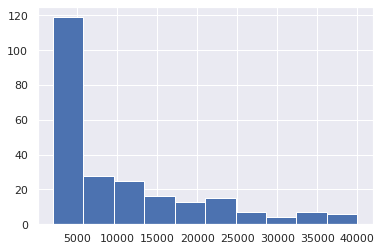

In [9]:
df['Temperature (K)'].hist()

### luminosity

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64


<AxesSubplot:>

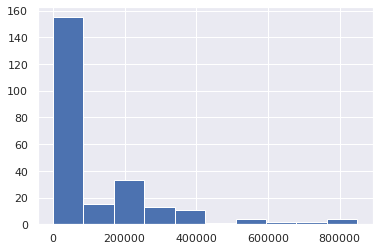

In [10]:
print(df['Luminosity(L/Lo)'].describe())
df['Luminosity(L/Lo)'].hist()

### radius

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64


<AxesSubplot:>

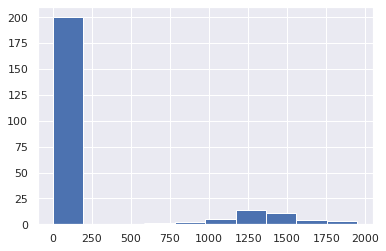

In [11]:
print(df['Radius(R/Ro)'].describe())
df['Radius(R/Ro)'].hist()

In [12]:
df = df[df['Radius(R/Ro)'] < 500]

<AxesSubplot:>

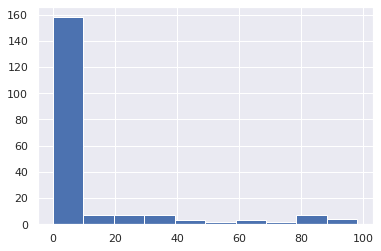

In [13]:
df['Radius(R/Ro)'].hist()

Редкие значения радиуса были удалены.

### absolute magnitude

<AxesSubplot:>

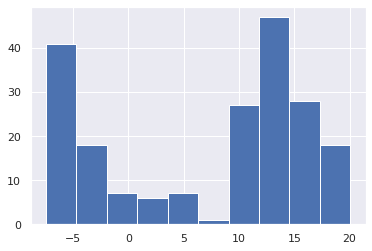

In [14]:
df['Absolute magnitude(Mv)'].hist()

### star type

In [15]:
df['Star type'].value_counts()

0    40
1    40
2    40
3    40
4    40
Name: Star type, dtype: int64

### star color

In [16]:
df['Star color'].value_counts()

Red                   89
Blue                  48
Blue-white            20
Blue White            10
yellow-white           8
White                  5
Yellowish White        3
Blue white             3
white                  3
Whitish                2
yellowish              2
Orange-Red             1
White-Yellow           1
Yellowish              1
Pale yellow orange     1
Blue white             1
Blue-White             1
Blue                   1
Name: Star color, dtype: int64

In [17]:
df['Star color'] = df['Star color'].str.lower()
df['Star color'] = df['Star color'].str.replace('blue white', 'blue-white')
df['Star color'] = df['Star color'].str.replace('yellowish white', 'yellow-white')
df['Star color'] = df['Star color'].str.replace('whitish', 'white')
df['Star color'] = df['Star color'].str.replace('white-yellow', 'yellow-white')
df['Star color'] = df['Star color'].str.replace('blue ', 'blue')
df['Star color'] = df['Star color'].str.replace('blue-white ', 'blue-white')
df['Star color'] = df['Star color'].str.replace('orange-red', 'orange')
df['Star color'] = df['Star color'].str.replace('pale yellow orange', 'orange')


In [18]:
df['Star color'].value_counts()

red             89
blue            49
blue-white      35
yellow-white    12
white           10
yellowish        3
orange           2
Name: Star color, dtype: int64

Повторяющиеся и редкие категории были объеденены с другими.

### Вывод

В датасете малое количество записей, что негативно влияет на обучение. Для решения этой проблемы будет использована аугментация данных.

### Аугментация данных

In [19]:
def augment_data(data, col_name, range_high, range_low, rand_high, rand_low, n_new):
    df = data[(data[col_name] > range_low) & (data[col_name] < range_high)]
    df = df.sample(n=n_new, replace=True)
    df[col_name] = df[col_name].apply(lambda x: x + np.random.uniform(low=rand_low, high=rand_high))
    return pd.concat([data, df], ignore_index=True)

<AxesSubplot:>

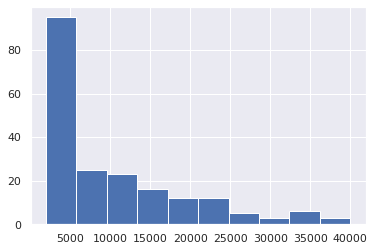

In [20]:
df['Temperature (K)'].hist()

In [21]:
df = augment_data(df, 'Temperature (K)', 40000, 15000, 1, -1, 50)

<AxesSubplot:>

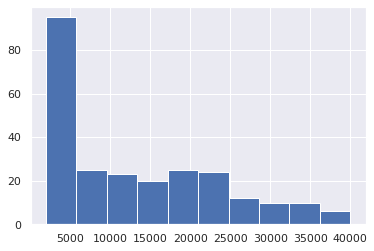

In [22]:
df['Temperature (K)'].hist()

С помощью функции аугментации в датасет было добавлено 50 новых записей.

## Построение базовой нейронной сети

In [23]:
X = df.drop('Temperature (K)', axis=1)
y = df['Temperature (K)']
X = pd.get_dummies(X, columns=['Star type', 'Star color'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
star_num = y_test.index

In [24]:
norm = Normalizer()
norm.fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

In [25]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [26]:
class NeuralNet(nn.Module):
    def __init__(self, n_inputs, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_outputs):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_inputs, n_hidden_neurons_1)   
        self.batchnorm_1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.batchnorm_2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.batchnorm_3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_outputs)
        self.relu = nn.ReLU()
 
    def forward(self, x):
        out = self.fc1(x)
        out = self.batchnorm_1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.batchnorm_2(out)
        out = self.relu(out) 
        out = self.fc3(out) 
        out = self.batchnorm_3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [27]:
n_inputs = 13
n_hidden_neurons_1 = 26
n_hidden_neurons_2 = 26
n_hidden_neurons_3 = 26
n_outputs = 1
learning_rate = 1e-3

In [28]:
def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

In [29]:
net = NeuralNet(n_inputs, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_outputs)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [30]:
n_epochs = 5000
batch_size = 20
train_loss = []
test_loss = []
epoch_list = []
best_loss = 1e10
best_weights = net.state_dict() 


num_batches = ceil(len(X_train)/batch_size)


for epoch in range(n_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        train_pred = net(X_batch) 
        test_pred = net(X_test)
        loss = loss_fn(train_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step() 
        if loss_fn(test_pred, y_test.unsqueeze(1)) < best_loss:
            best_weights = net.state_dict() 
            best_loss = loss_fn(test_pred, y_test.unsqueeze(1)) 
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            train_pred = net(X_train)
            train_loss.append(np.sqrt(loss_fn(train_pred, y_train.unsqueeze(1)).item())) 
            test_loss.append(np.sqrt(loss_fn(test_pred, y_test.unsqueeze(1)).item())) 
            epoch_list.append(epoch)      
    

In [31]:
np.sqrt(best_loss.item()) 

5167.868999887672

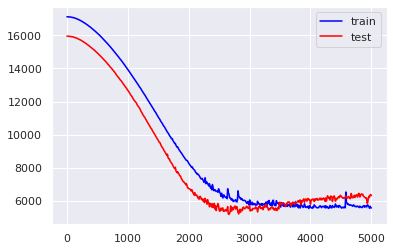

In [32]:
sns.lineplot(x=epoch_list, y=train_loss, color='blue')
sns.lineplot(x=epoch_list, y=test_loss, color='red')
plt.legend(['train', 'test'])

In [33]:
net.load_state_dict(best_weights)
predictions = net(X_test) 
predictions = predictions.flatten().tolist()
fact = y_test.flatten().tolist()

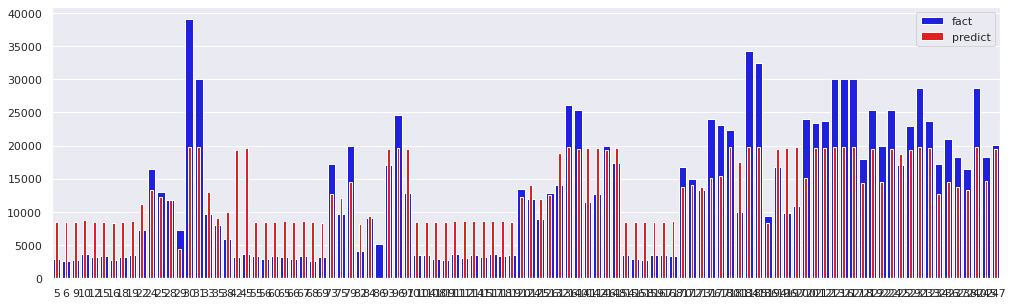

In [34]:
plt.figure(figsize=(17,5))
sns.barplot(x=star_num, y=fact, color='blue', label='fact')
sns.barplot(x=star_num, y=predictions, color='red', width=0.3, label='predict')
plt.legend()

### Вывод

Была создана нейросеть с тремя скрытыми слоями по 26 нейронов. Для всех слоёв была использована функция активации Relu. Также к скрытым слоям была применена функция Batch Normalization. После 5000 эпох, наилучший RMSE составил 5167.

Исходя из графика факт-прогноз, модель больше ошибается на звездах с высокими температурами. Предположительно, это вызвано редкостью таких звезд в датасете. Также, почти одинаково плохо предсказаны низкие значения, скорее всего по той же причине.

## Улучшение нейронной сети

In [35]:
net_baseline = net

In [36]:
class NeuralNet(nn.Module):
    def __init__(self, n_inputs, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_outputs, dropout_frac_1, dropout_frac_2):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_inputs, n_hidden_neurons_1) 
        self.batchnorm_1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.batchnorm_2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.batchnorm_3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_outputs)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_frac_1)
        self.dropout2 = nn.Dropout(dropout_frac_2)
 
    def forward(self, x):
        out = self.fc1(x)
        out = self.batchnorm_1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.batchnorm_2(out)
        out = self.relu(out) 
        out = self.dropout2(out)
        out = self.fc3(out) 
        out = self.batchnorm_3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [37]:
n_inputs = 13
n_hidden_neurons_1 = 26
n_hidden_neurons_2 = 26
n_hidden_neurons_3 = 26
n_outputs = 1
learning_rate = 1e-3

In [38]:
n_epochs = 3000
batches = list(range(20, 100, 20))
best_batches = 0
dropout_list = np.arange(0.2, 1.2, 0.2)
best_dropout = 0
best_loss = 1e10
best_weights = net.state_dict()
for dropout_n in dropout_list:
    print(dropout_n)
    for batch_size in batches:
        print(batch_size)
        net = NeuralNet(n_inputs, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_outputs, dropout_n, dropout_n)
        net.apply(init_weights)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()
        num_batches = ceil(len(X_train)/batch_size)
        for epoch in range(n_epochs):
            order = np.random.permutation(len(X_train))
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size
                optimizer.zero_grad()
                batch_indexes = order[start_index:start_index+batch_size]
                X_batch = X_train[batch_indexes]
                y_batch = y_train[batch_indexes]
                train_pred = net(X_batch) 
                test_pred = net(X_test)
                loss = loss_fn(train_pred, y_batch.unsqueeze(1))
                loss.backward()
                optimizer.step() 
                if loss_fn(test_pred, y_test.unsqueeze(1)) < best_loss:
                    best_weights = net.state_dict() 
                    best_loss = loss_fn(test_pred, y_test.unsqueeze(1)) 
                    best_batches = batch_size  
                    best_dropout = dropout_n
                    if np.sqrt(best_loss.item()) < 5500:
                        print(np.sqrt(best_loss.item()))
    

0.2
20
5449.863117547082
5391.399632748438
5367.127350827443
5289.350054590828
5229.936519691229
5176.429078042121
5128.533708575971
5025.567629631502
5001.619137839266
4987.724130302317
4960.710231408402
40
60
80
0.4
20
4887.895252560144
40
60
80
0.6000000000000001
20
40
60
80
0.8
20
40
60
80
1.0
20
40
60
80


In [39]:
print(best_batches)
print(best_dropout)
np.sqrt(best_loss.item()) 

20
0.4


4887.895252560144

In [40]:
net = NeuralNet(n_inputs, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_outputs, best_dropout, best_dropout)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [41]:
learning_rate = 0.005

In [42]:
n_epochs = 5000
batch_size = best_batches
train_loss = []
test_loss = []
epoch_list = []
best_loss = 1e10
best_weights = net.state_dict() 


num_batches = ceil(len(X_train)/batch_size)


for epoch in range(n_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        train_pred = net(X_batch) 
        test_pred = net(X_test)
        loss = loss_fn(train_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step() 
        if loss_fn(test_pred, y_test.unsqueeze(1)) < best_loss:
            best_weights = net.state_dict() 
            best_loss = loss_fn(test_pred, y_test.unsqueeze(1)) 
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            train_pred = net(X_train)
            train_loss.append(np.sqrt(loss_fn(train_pred, y_train.unsqueeze(1)).item())) 
            test_loss.append(np.sqrt(loss_fn(test_pred, y_test.unsqueeze(1)).item())) 
            epoch_list.append(epoch)      
    

In [43]:
np.sqrt(best_loss.item())

4571.095054798139

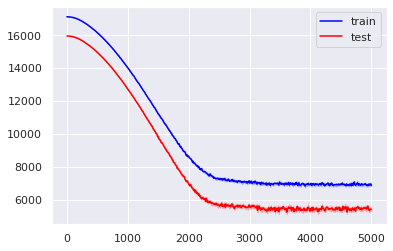

In [44]:
sns.lineplot(x=epoch_list, y=train_loss, color='blue')
sns.lineplot(x=epoch_list, y=test_loss, color='red')
plt.legend(['train', 'test'])

### Вывод
В изначальную модель было добавлено два слоя dropout. С помощью цикла на уменьшенном(3000) количестве эпох были подобраны оптимальный размер батча и процент dropout - 20 и 0.4. При обучении с нормальным(5000) количеством эпох и со скоростью обучения 0.005 было получено значение RMSE 4571. 

## Выводы

In [47]:
net.load_state_dict(best_weights)
predictions = net(X_test) 
predictions = predictions.flatten().tolist()
fact = y_test.flatten().tolist() 

In [45]:
net = net_baseline
predictions_baseline = net(X_test) 
predictions_baseline = predictions_baseline.flatten().tolist()

Text(0.5, 1.0, 'сравнение моделей')

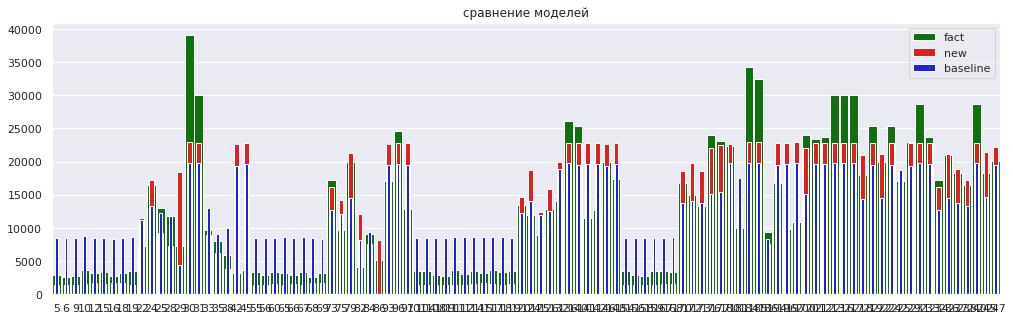

In [55]:
plt.figure(figsize=(17,5))
sns.barplot(x=star_num, y=fact, color='green',width=0.9, label='fact')
sns.barplot(x=star_num, y=predictions, color='red', width=0.5, label='new')
sns.barplot(x=star_num, y=predictions_baseline, color='blue', width=0.3, label='baseline')

plt.legend()
plt.title('сравнение моделей')

Улучшенная модель показывает значительно лучшие результаты на звёздах с низкими и средними температурами. Ошибка на высоких температурах все ещё присутствует, но меньше чем в baseline модели.